# Scrape and download - Introduction
This is the first part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook scrapes and downloads the necessary information from the website.

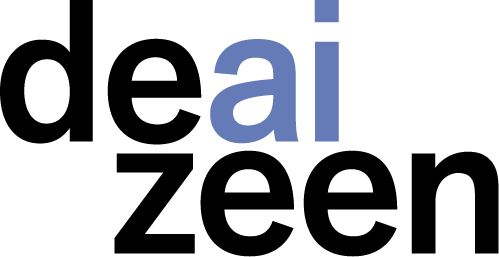

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runti"me
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive
!ls /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
1-ScrapeAndDownload.ipynb  dezeen_4-model.ipynb		    files
classes.gsheet		   dezeen_5-database.ipynb	    LICENSE
darknet			   dezeen_6-colorrecognition.ipynb  OIDv4_ToolKit
data			   dezeen_7-test.ipynb		    README.md
dezeen_2-download.ipynb    dezeenAI
dezeen_3-dataset.ipynb	   dezeenai.png
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
Let's now import the necessary libraries and function we're gonna use in this notebook.

- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm.notebook` - loop progress bar for notebooks
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions
- `os` - operating system interfaces
- `os.path` - pathname manipulation
- `json` - JSON files handling

In [3]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import tqdm.notebook as tq
import timeit
import numpy as np
import pandas as pd
import sys
import os
from os.path import basename
import json

# Scraping
Let's now retrieve all the information we need to proceed.

## List of subpages
First let's get a list of available subpages of [Dezeen.com](http://dezeen.com/)'s `Interior` category using its url naming convention: `/interiors/page/1/`, `/interiors/page/2/` and so on.

1. Initiate the pages container and the counter variable.
2. Run a loop through the subpages until the response status code is no longer `200`, save their urls and responses to a list.
3. Display first 5 rows of the list

In [4]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few minutes to complete...\n')

# initiate subpages container and counter variable
pages = []
counter = 1

# initiate a default http request
url = 'https://www.dezeen.com/interiors/page/1'
response = requests.get(url)

# iterate through the urls until the status code is ok
while response.status_code == 200:

  # perform a http request
  url = 'https://www.dezeen.com/interiors/page/'+str(counter)
  response = requests.get(url)

  # append the url and request response to the container
  pages.append((url, response))

  # increase the counter value by 1
  counter += 1

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))

len(pages)


Starting. This might take a few minutes to complete...

Runtime: 30 seconds.


251

## Articles info
Let's scrape a list of articles tagged as `Interior` using [Dezeen.com](http://dezeen.com/)'s category pagination url convention: `/interiors/page/1/`, `/interiors/page/2/` and so on.

1. Iterate through the list of subpages
3. Initiate a `BeautifulSoup` object and find all `<arcticle>` objects with a `data-article-id` attribute present (each one of these indicate a unique article container)
4. Iterate through the article objects and scrape the id, title and url of each one of them

In [5]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few seoncds to complete...\n')

# initiate the list of containers
ids = []
titles = []
urls = []

for page in tq.tqdm(pages):

  # perform a http request
  url = page[0]
  response = page[1]

  # initiate BeautifulSoup and find objects of our interest
  soup = BeautifulSoup(response.content, 'html.parser')
  articles = soup.find_all('article', attrs={'data-article-id': True})

  # iterate through the objects we found and extract the information we need
  for article in articles:
    ids.append(article['data-article-id'])
    titles.append(article.h3.string)
    urls.append(article.a['href'])

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few seoncds to complete...




Runtime: 20 seconds.


## Articles DataFrame
Let's put all the articles' information we've gathered together. To do so, let's create a DataFrame using aggregated lists and save the scraped information to a DataFrame.

In [6]:
# aggregate the ids, titles and url into list of tuples
articles_df = pd.DataFrame(
    data = list(zip(ids, titles, urls)),
    columns = ['id', 'title', 'url'])
articles_df

,id,title,url
0,1595387,Enter Projects Asia weaves rattan sculptures t...,https://www.dezeen.com/2020/12/10/enter-projec...
1,1595544,AHEAD Global reveals the world's best hotel de...,https://www.dezeen.com/2020/12/10/ahead-global...
2,1594909,Defhouse in Milan is a home for Italy's up-and...,https://www.dezeen.com/2020/12/09/defhouse-mil...
3,1594490,Pantechnicon store in London infuses Japanese ...,https://www.dezeen.com/2020/12/08/pantechnicon...
4,1594339,"Still Room in Antwerp is designed to be a ""she...",https://www.dezeen.com/2020/12/07/still-room-a...
...,...,...,...
4980,70,Marcel Wanders launches Crochet Chair,https://www.dezeen.com/2006/12/10/marcel-wande...
4981,67,WOKmedia show at Design Miami,https://www.dezeen.com/2006/12/10/wokmedia-sho...
4982,54,Zaha Hadid furniture exhibited in New York,https://www.dezeen.com/2006/12/07/zaha-hadid-f...
4983,48,Thomas Heatherwick beach cafe takes shape,https://www.dezeen.com/2006/12/04/thomas-heath...


## Article images
Let's retireve a list of images in each article.

1. Iterate through the article urls
2. Create a `BeautifulSoup` object and find all `<figure>` elements with `id` attribute present.
4. Iterate through the figures to retrieve and save an image source for each of `<figure>` objects.

In [7]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take over an hour or two to complete...\n')

# initiate the images container
article_images = []

# iterate through the url column
for url in tq.tqdm(articles_df['url']):
    
  # perform a http request
  response = requests.get(url)

  # initiate BeautifulSoup and find objects of our interest
  soup = BeautifulSoup(response.content, 'html.parser')
  figures = soup.find_all('figure', attrs={'id': True})

  # iterate through the objects we found and create a list of image urls
  imgs = []
  for figure in figures:
    if figure.img is not None:
      imgs.append(figure.img['data-src'])
  
  article_images.append(imgs)
    
# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take over an hour or two to complete...




Runtime: 6321 seconds.


## Images column
Add a column of lists of image urls for each article to the existing DataFrame.

In [8]:
articles_df['images'] = article_images
articles_df

,id,title,url,images
0,1595387,Enter Projects Asia weaves rattan sculptures t...,https://www.dezeen.com/2020/12/10/enter-projec...,[https://static.dezeen.com/uploads/2020/12/spi...
1,1595544,AHEAD Global reveals the world's best hotel de...,https://www.dezeen.com/2020/12/10/ahead-global...,[https://static.dezeen.com/uploads/2020/12/ahe...
2,1594909,Defhouse in Milan is a home for Italy's up-and...,https://www.dezeen.com/2020/12/09/defhouse-mil...,[https://static.dezeen.com/uploads/2020/12/def...
3,1594490,Pantechnicon store in London infuses Japanese ...,https://www.dezeen.com/2020/12/08/pantechnicon...,[https://static.dezeen.com/uploads/2020/12/pan...
4,1594339,"Still Room in Antwerp is designed to be a ""she...",https://www.dezeen.com/2020/12/07/still-room-a...,[https://static.dezeen.com/uploads/2020/12/sti...
...,...,...,...,...
4980,70,Marcel Wanders launches Crochet Chair,https://www.dezeen.com/2006/12/10/marcel-wande...,[https://static.dezeen.com/uploads/2006/12/Mar...
4981,67,WOKmedia show at Design Miami,https://www.dezeen.com/2006/12/10/wokmedia-sho...,[https://static.dezeen.com/uploads/2006/12/WOK...
4982,54,Zaha Hadid furniture exhibited in New York,https://www.dezeen.com/2006/12/07/zaha-hadid-f...,[https://static.dezeen.com/uploads/2006/12/Zah...
4983,48,Thomas Heatherwick beach cafe takes shape,https://www.dezeen.com/2006/12/04/thomas-heath...,[https://static.dezeen.com/uploads/2006/12/Tho...


## Export
Let's export the DataFrame to a pickle file to preserve list values.

In [9]:
# increase the maximum depth of the Python interpreter to avoid an overflow error
sys.setrecursionlimit(10000)

# export
articles_df.to_pickle('files/articles.pkl')

# Files download

## Download files

1. Iterate through rows of the DataFrame (articles)
2. Create a unique folder for each article to store the files
3. Save a JSON file in every folder containing meta data about each article
4. Iterate through the list of images for each article to download the images and save their meta data.

In [19]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few hours to complete...\n')

# initiate containers for image path, url and it's parent article id
imgpaths = []
imgurls = []
artids = []

# loop through each article in the DataFrame
for _, row in tq.tqdm(articles_df.iterrows()):
  
  # extract values for each column
  id = row['id']
  title = row['title']  
  url = row['url']
  images = row['images']

  # create a directory for each article if doesn't exist
  path = 'data/dezeen/'+str(id)+'/'
  os.makedirs(path, exist_ok=True)
  
  # create a dictionary of meta data
  info = {
      'id': id,
      'title': title,
      'url': url,
      'images': images
  }

  # save the meta data for each article in a JSON file
  jsonpath = 'data/dezeen/'+str(id)+'/'+str(id)+'.json'
  if not os.path.exists(jsonpath):
    with open(jsonpath, 'w') as fp:
      json.dump(info, fp)

  # loop thourgh the list of images for each article
  for image in images:
    
    # extract filename from the url
    filename = basename(image)    

    # check if file exists
    if not os.path.exists(path+filename):

      # try downloading the image
      try:
        urllib.request.urlretrieve(image, path+filename)
      # break out of the loop if error encountered
      except: break
    
    # extract image path, uurl and its parent article id
    imgpaths.append('/mydrive/'+path+filename)
    imgurls.append(image)
    artids.append(id)

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few hours to complete...




Runtime: 26 seconds.


## Images DataFrame
Let's create and export a DataFrame containing all images in the dataset for later notebooks.

In [21]:
# aggregate the paths, urls and ids into list of tuples
images_df = pd.DataFrame(
    data = list(zip(artids, imgurls, imgpaths)),
    columns = ['id', 'url', 'path'])
images_df

,id,url,path
0,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
1,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
2,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
3,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
4,1595387,https://static.dezeen.com/uploads/2020/12/spic...,/mydrive/data/dezeen/1595387/spice-and-barley-...
...,...,...,...
47172,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg
47173,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg
47174,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg
47175,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg


## Export
Let's export the DataFrame for later use in other notebooks. This time csv export will be just fine.

In [22]:
# export to csv file
images_df.to_csv('files/images.csv')